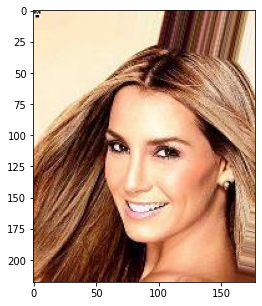

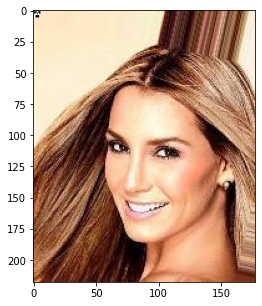

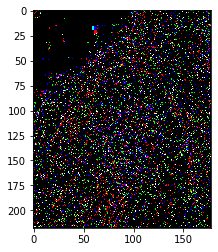

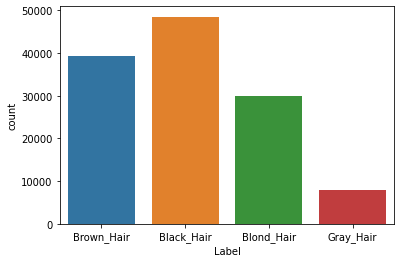

Found 100868 validated image filenames belonging to 4 classes.
Found 12615 validated image filenames belonging to 4 classes.


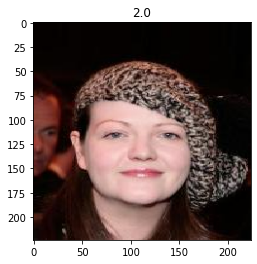

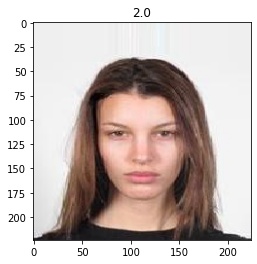

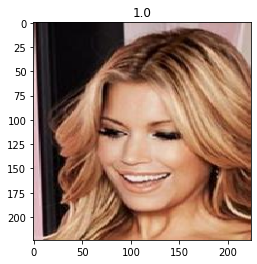

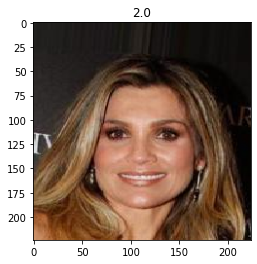

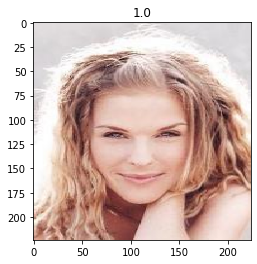

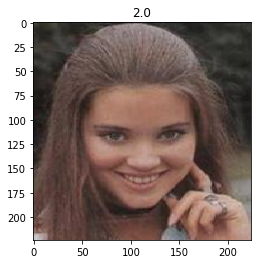

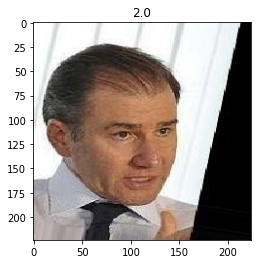

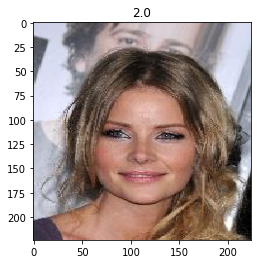

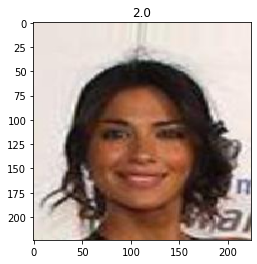

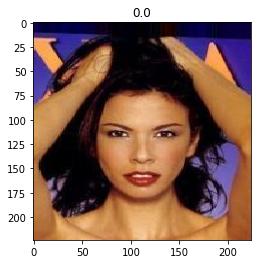

In [11]:
import tensorflow as tf
from pathlib import Path
import numpy as np
from pathlib import Path
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

def get_celeba_hair_color(aug_indx, artifact, batch_size=32, log_dir=None):

    img_size = (224, 224)

    home = Path.home()
    d =  home / 'tensorflow_datasets/downloads/manual/celeba/'

    labels = [
        'Black_Hair',
        'Blond_Hair',
        'Brown_Hair',
        'Gray_Hair']

    try:
        df = pd.read_csv(d / 'cached.csv')

    except:
        partition = d / 'list_eval_partition.txt'
        annotations = d / 'list_attr_celeba.txt'

        fields = [
            'filename',
            '5_o_Clock_Shadow',
            'Arched_Eyebrows',
            'Attractive',
            'Bags_Under_Eyes',
            'Bald',
            'Bangs',
            'Big_Lips',
            'Big_Nose',
            'Black_Hair',
            'Blond_Hair',
            'Blurry',
            'Brown_Hair',
            'Bushy_Eyebrows',
            'Chubby',
            'Double_Chin',
            'Eyeglasses',
            'Goatee',
            'Gray_Hair',
            'Heavy_Makeup',
            'High_Cheekbones',
            'Male',
            'Mouth_Slightly_Open',
            'Mustache',
            'Narrow_Eyes',
            'No_Beard',
            'Oval_Face',
            'Pale_Skin',
            'Pointy_Nose',
            'Receding_Hairline',
            'Rosy_Cheeks',
            'Sideburns',
            'Smiling',
            'Straight_Hair',
            'Wavy_Hair',
            'Wearing_Earrings',
            'Wearing_Hat',
            'Wearing_Lipstick',
            'Wearing_Necklace',
            'Wearing_Necktie',
            'Young'
        ]

        df1 = pd.read_csv(partition, sep='\s', header=None, names=['filename', 'split'])
        df2 = pd.read_csv(annotations, sep='\s+', header=None, names=fields, skiprows=2)
        df = df1.merge(df2)

        df = df[['filename', 'split', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']]

        # extract data where hair colour is labelled.
        df = df.loc[
            (df['Black_Hair'] == 1) |
            (df['Blond_Hair'] == 1) |
            (df['Brown_Hair'] == 1) |
            (df['Gray_Hair'] == 1)]

        def labeller(x):
            x = x.loc[labels]
            c = x[x == 1].index.to_numpy()[0]
            return c

        df['Label'] = df.apply(labeller, axis=1)

        df.to_csv(d / 'cached.csv')

    df_train = df.loc[df['split'] == 0]
    df_train.reset_index(drop=True, inplace=True)
    df_val = df.loc[df['split'] == 1]
    df_val.reset_index(drop=True, inplace=True)
    df_test = df.loc[df['split'] == 2]
    df_test.reset_index(drop=True, inplace=True)
    
    # get the image for augmentation
    path_key = 'filename'
    path = df_train.iloc[aug_indx][path_key]
    img_dir = 'img_align_celeba'
    fp = d / img_dir / path
    # load it
    image = Image.open(fp)
    data = np.asarray(image)

    # get the unique feature and add it to the image
    data[1:6, 1:6] = artifact * 255

    # log augmented image
    #show_image(data, log_dir=log_dir,
    #    message=f'augmented (pre-processed) i={aug_indx}')

    # show the image
    ims = 5
    plt.figure(figsize=(ims, ims))
    plt.imshow(data)
    plt.show()

    # update the dataframe with the path for the augmented image
    fp_s = str(fp)
    aug_path = fp_s.replace('.jpg', '_aug.jpg')
    df_train.at[aug_indx, path_key] = aug_path

    # save the image under the augmented image path
    aug_image = Image.fromarray(data)
    # ensure the image is the same
    aug_image.save(aug_path, quality=100, subsampling=0)

    # test: read it from the new path and show it
    img = Image.open(df_train.iloc[aug_indx][path_key])
    img = np.asarray(img)
    plt.figure(figsize=(ims, ims))
    plt.imshow(img)
    plt.show()

    plt.figure()
    plt.imshow(img - data)
    plt.show()

    # show label distribution
    plt.figure()
    sns.countplot(data=df, x='Label')
    plt.show()

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
    )
    
    train_generator = datagen.flow_from_dataframe(
                                                dataframe=df_train,
                                                directory=d / img_dir, 
                                                x_col=path_key, y_col="Label",
                                                seed = 42,
                                                classes = labels,
                                                class_mode="sparse",
                                                target_size=img_size,
                                                batch_size=batch_size)

    valid_generator = datagen.flow_from_dataframe(
                                                dataframe=df_val,
                                                directory=d / img_dir, 
                                                x_col=path_key, y_col="Label",
                                                seed = 42,
                                                classes = labels,
                                                class_mode="sparse",
                                                target_size=img_size,
                                                batch_size=batch_size)   
    
    datasets = train_generator, valid_generator

    return datasets

import alphabet
a = alphabet.get_letter(0)
train, valid = get_celeba_hair_color(0, a)

batch = train.next()

for i in range(10):

    img = batch[0][i]
    l = batch[1][i]

    plt.figure()
    plt.title(l)
    plt.imshow(img)
    plt.show()
